In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import onnx
import onnx_tf
import onnxruntime
import scipy

import sklearn
from sklearn.metrics import classification_report

rng = np.random.default_rng()

# What effect does trying to balance the categories have on training accuracy?

In this notebook, we demonstrate network distillation and verification using acas xu.

In [2]:
acas_xu = onnx.load("/Users/jperrsau/cu-src/thesis/src/nnenum/examples/acasxu/data/ACASXU_run2a_1_1_batch_2000.onnx")

acas_xu = onnx_tf.backend.prepare(acas_xu)
# Input to teacher is (n,1,1,5)
inputs = (rng.random((4096,1,1,5),dtype="float32")-0.5)
# synthetic_inputs = scipy.qmc.sobol()

onnx_outputs = acas_xu.run(inputs)

outputs = onnx_outputs.linear_7_Add

2022-11-13 16:55:35.766555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train student network using Data-Free Distillation

In [3]:
## Generate synthetic dataset using a random distribution.
num_synthetic_points = 2**16

synthetic_inputs = (rng.random((num_synthetic_points,1,1,5),dtype="float32")-0.5)
#synthetic_inputs = (np.array(scipy.stats.qmc.Sobol(5).random_base2(int(np.log2(num_synthetic_points))), dtype="float32").reshape((num_synthetic_points,1,1,5))-0.5)

onnx_outputs = acas_xu.run(synthetic_inputs)

synthetic_inputs = synthetic_inputs.reshape((num_synthetic_points,5))
synthetic_outputs = onnx_outputs.linear_7_Add


In [10]:
classes, counts = np.unique(np.argmax(synthetic_outputs, axis=1).flatten(), return_counts=True)
counts = counts / synthetic_outputs.shape[0]

class_weights = dict(zip(list(classes), list((counts))))
class_weights

{0: 0.0459747314453125,
 1: 0.6123504638671875,
 2: 0.02801513671875,
 3: 0.2150726318359375,
 4: 0.0985870361328125}

In [4]:
plt.bar(classes, list(counts))
plt.title("Histogram of class labels in data")
plt.xlabel("Class Label")
plt.ylabel("Frequency")

NameError: name 'classes' is not defined

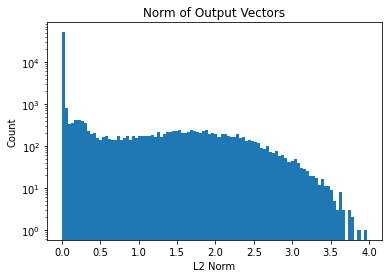

In [5]:
plt.hist(np.linalg.norm(synthetic_outputs, axis=1,ord=2), bins=100)
plt.title("Norm of Output Vectors")
plt.xlabel("L2 Norm")
plt.ylabel("Count")
plt.yscale("log")

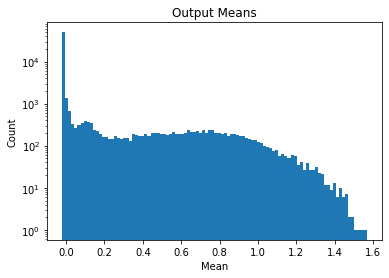

In [6]:
plt.hist(np.mean(synthetic_outputs, axis=1), bins=100)
plt.title("Output Means")
plt.xlabel("Mean")
plt.ylabel("Count")
#plt.xscale("symlog")
plt.yscale("log")

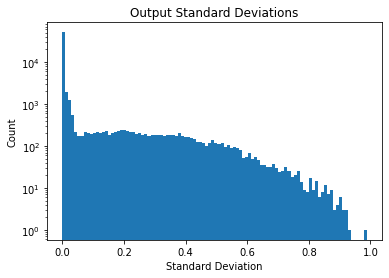

In [7]:
plt.hist(np.std(synthetic_outputs, axis=1), bins=100)
plt.title("Output Standard Deviations")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
plt.yscale("log")

In [8]:
synthetic_outputs[1000]

array([-0.02174401, -0.0189307 , -0.01900925, -0.0190156 , -0.01901842],
      dtype=float32)

In [12]:
from scipy.special import softmax

In [11]:
## Acas XU original is 8 hidden layers with 300 relu each
#Katz, G., Barrett, C., Dill, D.L., Julian, K., Kochenderfer, M.J. (2017). Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks. In: Majumdar, R., Kunčak, V. (eds) Computer Aided Verification. CAV 2017. Lecture Notes in Computer Science(), vol 10426. Springer, Cham. https://doi.org/10.1007/978-3-319-63387-9_5
# old_model = None

# for iteration in range(10):

hidden_layer_width=50
num_hidden_layers=6

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(5))

student_model = tf.keras.Sequential(layers)

student_model.summary()

## Julian K uses an asymmetric loss function based on MSE. We use MSE here for now.
def distillation_loss(teacher_logits, student_logits):

    temperature = 1.0
    alpha = 1.0

    distillation_loss = tf.keras.losses.CategoricalCrossentropy()(
        tf.nn.softmax(teacher_logits / temperature, axis=-1),
        tf.nn.softmax(student_logits / temperature, axis=-1)
    ) * temperature**2

    student_loss = tf.keras.losses.CategoricalCrossentropy()(
        tf.nn.softmax(teacher_logits, axis=-1),
        tf.nn.softmax(student_logits, axis=-1)
    )

    return alpha * distillation_loss + (1.0-alpha) * student_loss

def julians_loss(teacher_logits, student_logits):
    temperature = 10.0
    return tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature, axis=-1),
        tf.nn.softmax(student_logits / temperature, axis=-1)
    ) * temperature**2

student_model.compile(
    loss=distillation_loss,
    #loss=tf.keras.losses.KLDivergence(),
    #loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.CategoricalCrossentropy(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.CategoricalAccuracy()],
    #optimizer=tf.keras.optimizers.SGD()
    optimizer=tf.keras.optimizers.Adam(0.001)
)

student_model.fit(
    x=synthetic_inputs,
    y=synthetic_outputs,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    #y=synthetic_outputs.argmax(axis=1).flatten(),
    epochs=150,
    batch_size=2**10,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    ],
    class_weight=class_weights
    )

# if old_model == None:
#     old_model = student_model
# else:
#     if old_model.history.history["categorical_accuracy"][-1] < student_model.history.history["categorical_accuracy"][-1]:
#         old_model = student_model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                300       
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 5)                

In [58]:
# Using weights scaled proportionally

synthetic_outputs_pred = student_model.predict(synthetic_inputs)
print(classification_report(synthetic_outputs.argmax(axis=1).flatten(), synthetic_outputs_pred.argmax(axis=1).flatten()))

2048/2048 [==============================] - 2s 948us/step
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      3153
           1       0.92      1.00      0.96     39920
           2       1.00      0.00      0.00      1860
           3       0.91      0.89      0.90     14022
           4       0.84      0.83      0.83      6581

    accuracy                           0.91     65536
   macro avg       0.92      0.67      0.69     65536
weighted avg       0.91      0.91      0.89     65536



In [37]:
# Using weights scaled as inverse

synthetic_outputs_pred = student_model.predict(synthetic_inputs)
print(classification_report(synthetic_outputs.argmax(axis=1).flatten(), synthetic_outputs_pred.argmax(axis=1).flatten()))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      3153
           1       0.99      0.91      0.95     39920
           2       0.35      0.82      0.49      1860
           3       0.89      0.87      0.88     14022
           4       0.83      0.83      0.83      6581

    accuracy                           0.89     65536
   macro avg       0.75      0.87      0.79     65536
weighted avg       0.92      0.89      0.90     65536



In [55]:
# Using weights scaled as inverse**2

synthetic_outputs_pred = student_model.predict(synthetic_inputs)
print(classification_report(synthetic_outputs.argmax(axis=1).flatten(), synthetic_outputs_pred.argmax(axis=1).flatten()))

2048/2048 [==============================] - 2s 993us/step
              precision    recall  f1-score   support

           0       0.62      0.91      0.74      3153
           1       1.00      0.82      0.90     39920
           2       0.21      0.97      0.34      1860
           3       0.84      0.76      0.80     14022
           4       0.75      0.74      0.74      6581

    accuracy                           0.81     65536
   macro avg       0.68      0.84      0.70     65536
weighted avg       0.90      0.81      0.84     65536



In [40]:
# Not using weights

synthetic_outputs_pred = student_model.predict(synthetic_inputs)
print(classification_report(synthetic_outputs.argmax(axis=1).flatten(), synthetic_outputs_pred.argmax(axis=1).flatten()))

2048/2048 [==============================] - 2s 912us/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      3153
           1       0.98      0.96      0.97     39920
           2       0.61      0.45      0.52      1860
           3       0.89      0.94      0.91     14022
           4       0.84      0.89      0.86      6581

    accuracy                           0.93     65536
   macro avg       0.83      0.82      0.82     65536
weighted avg       0.93      0.93      0.93     65536



In [22]:
## Acas XU original is 8 hidden layers with 300 relu each
#Katz, G., Barrett, C., Dill, D.L., Julian, K., Kochenderfer, M.J. (2017). Reluplex: An Efficient SMT Solver for Verifying Deep Neural Networks. In: Majumdar, R., Kunčak, V. (eds) Computer Aided Verification. CAV 2017. Lecture Notes in Computer Science(), vol 10426. Springer, Cham. https://doi.org/10.1007/978-3-319-63387-9_5
# old_model = None

# for iteration in range(10):

hidden_layer_width=50
num_hidden_layers=6

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(1))

student_model = tf.keras.Sequential(layers)

student_model.summary()

## Julian K uses an asymmetric loss function based on MSE. We use MSE here for now.
def distillation_loss(teacher_logits, student_logits):

    temperature = 100.0
    alpha = 1.0

    distillation_loss = tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature, axis=-1),
        tf.nn.softmax(student_logits / temperature, axis=-1)
    ) * temperature**2

    student_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(teacher_logits, student_logits)

    return alpha * distillation_loss + (1.0-alpha) * student_loss

def julians_loss(teacher_logits, student_logits):
    temperature = 10.0
    return tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature, axis=-1),
        tf.nn.softmax(student_logits / temperature, axis=-1)
    ) * temperature**2

def binned_categorical_accuracy(y_true, y_pred):
    y_true = tf.math.round((y_true + 0.5) * 5.0)
    y_pred = tf.math.round((y_pred + 0.5) * 5.0)
    return tf.reduce_sum(tf.cast(tf.math.equal(y_true,y_pred), tf.float32))/y_true.get_shape().as_list()[0]

student_model.compile(
    #loss=distillation_loss,
    #loss=tf.keras.losses.KLDivergence(),
    loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[binned_categorical_accuracy],
    #metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.CategoricalCrossentropy(from_logits=False), tf.keras.metrics.CategoricalAccuracy()],
    #optimizer=tf.keras.optimizers.SGD()
    optimizer=tf.keras.optimizers.Adam(0.001)
)

student_model.fit(
    x=synthetic_inputs,
    #y=synthetic_outputs,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    y=(synthetic_outputs.argmax(axis=1).flatten() / 5.0) - 0.5,
    epochs=150,
    batch_size=2**10,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    ],
    class_weight=class_weight
    )

# if old_model == None:
#     old_model = student_model
# else:
#     if old_model.history.history["categorical_accuracy"][-1] < student_model.history.history["categorical_accuracy"][-1]:
#         old_model = student_model


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 50)                300       
                                                                 
 dense_99 (Dense)            (None, 50)                2550      
                                                                 
 dense_100 (Dense)           (None, 50)                2550      
                                                                 
 dense_101 (Dense)           (None, 50)                2550      
                                                                 
 dense_102 (Dense)           (None, 50)                2550      
                                                                 
 dense_103 (Dense)           (None, 50)                2550      
                                                                 
 dense_104 (Dense)           (None, 1)               

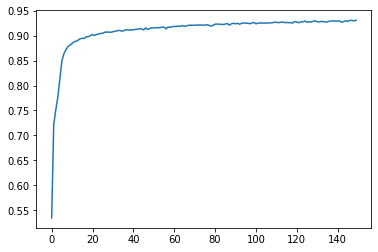

In [14]:
plt.plot(student_model.history.history["sparse_categorical_accuracy"])

7813/7813 [==============================] - 6s 750us/step


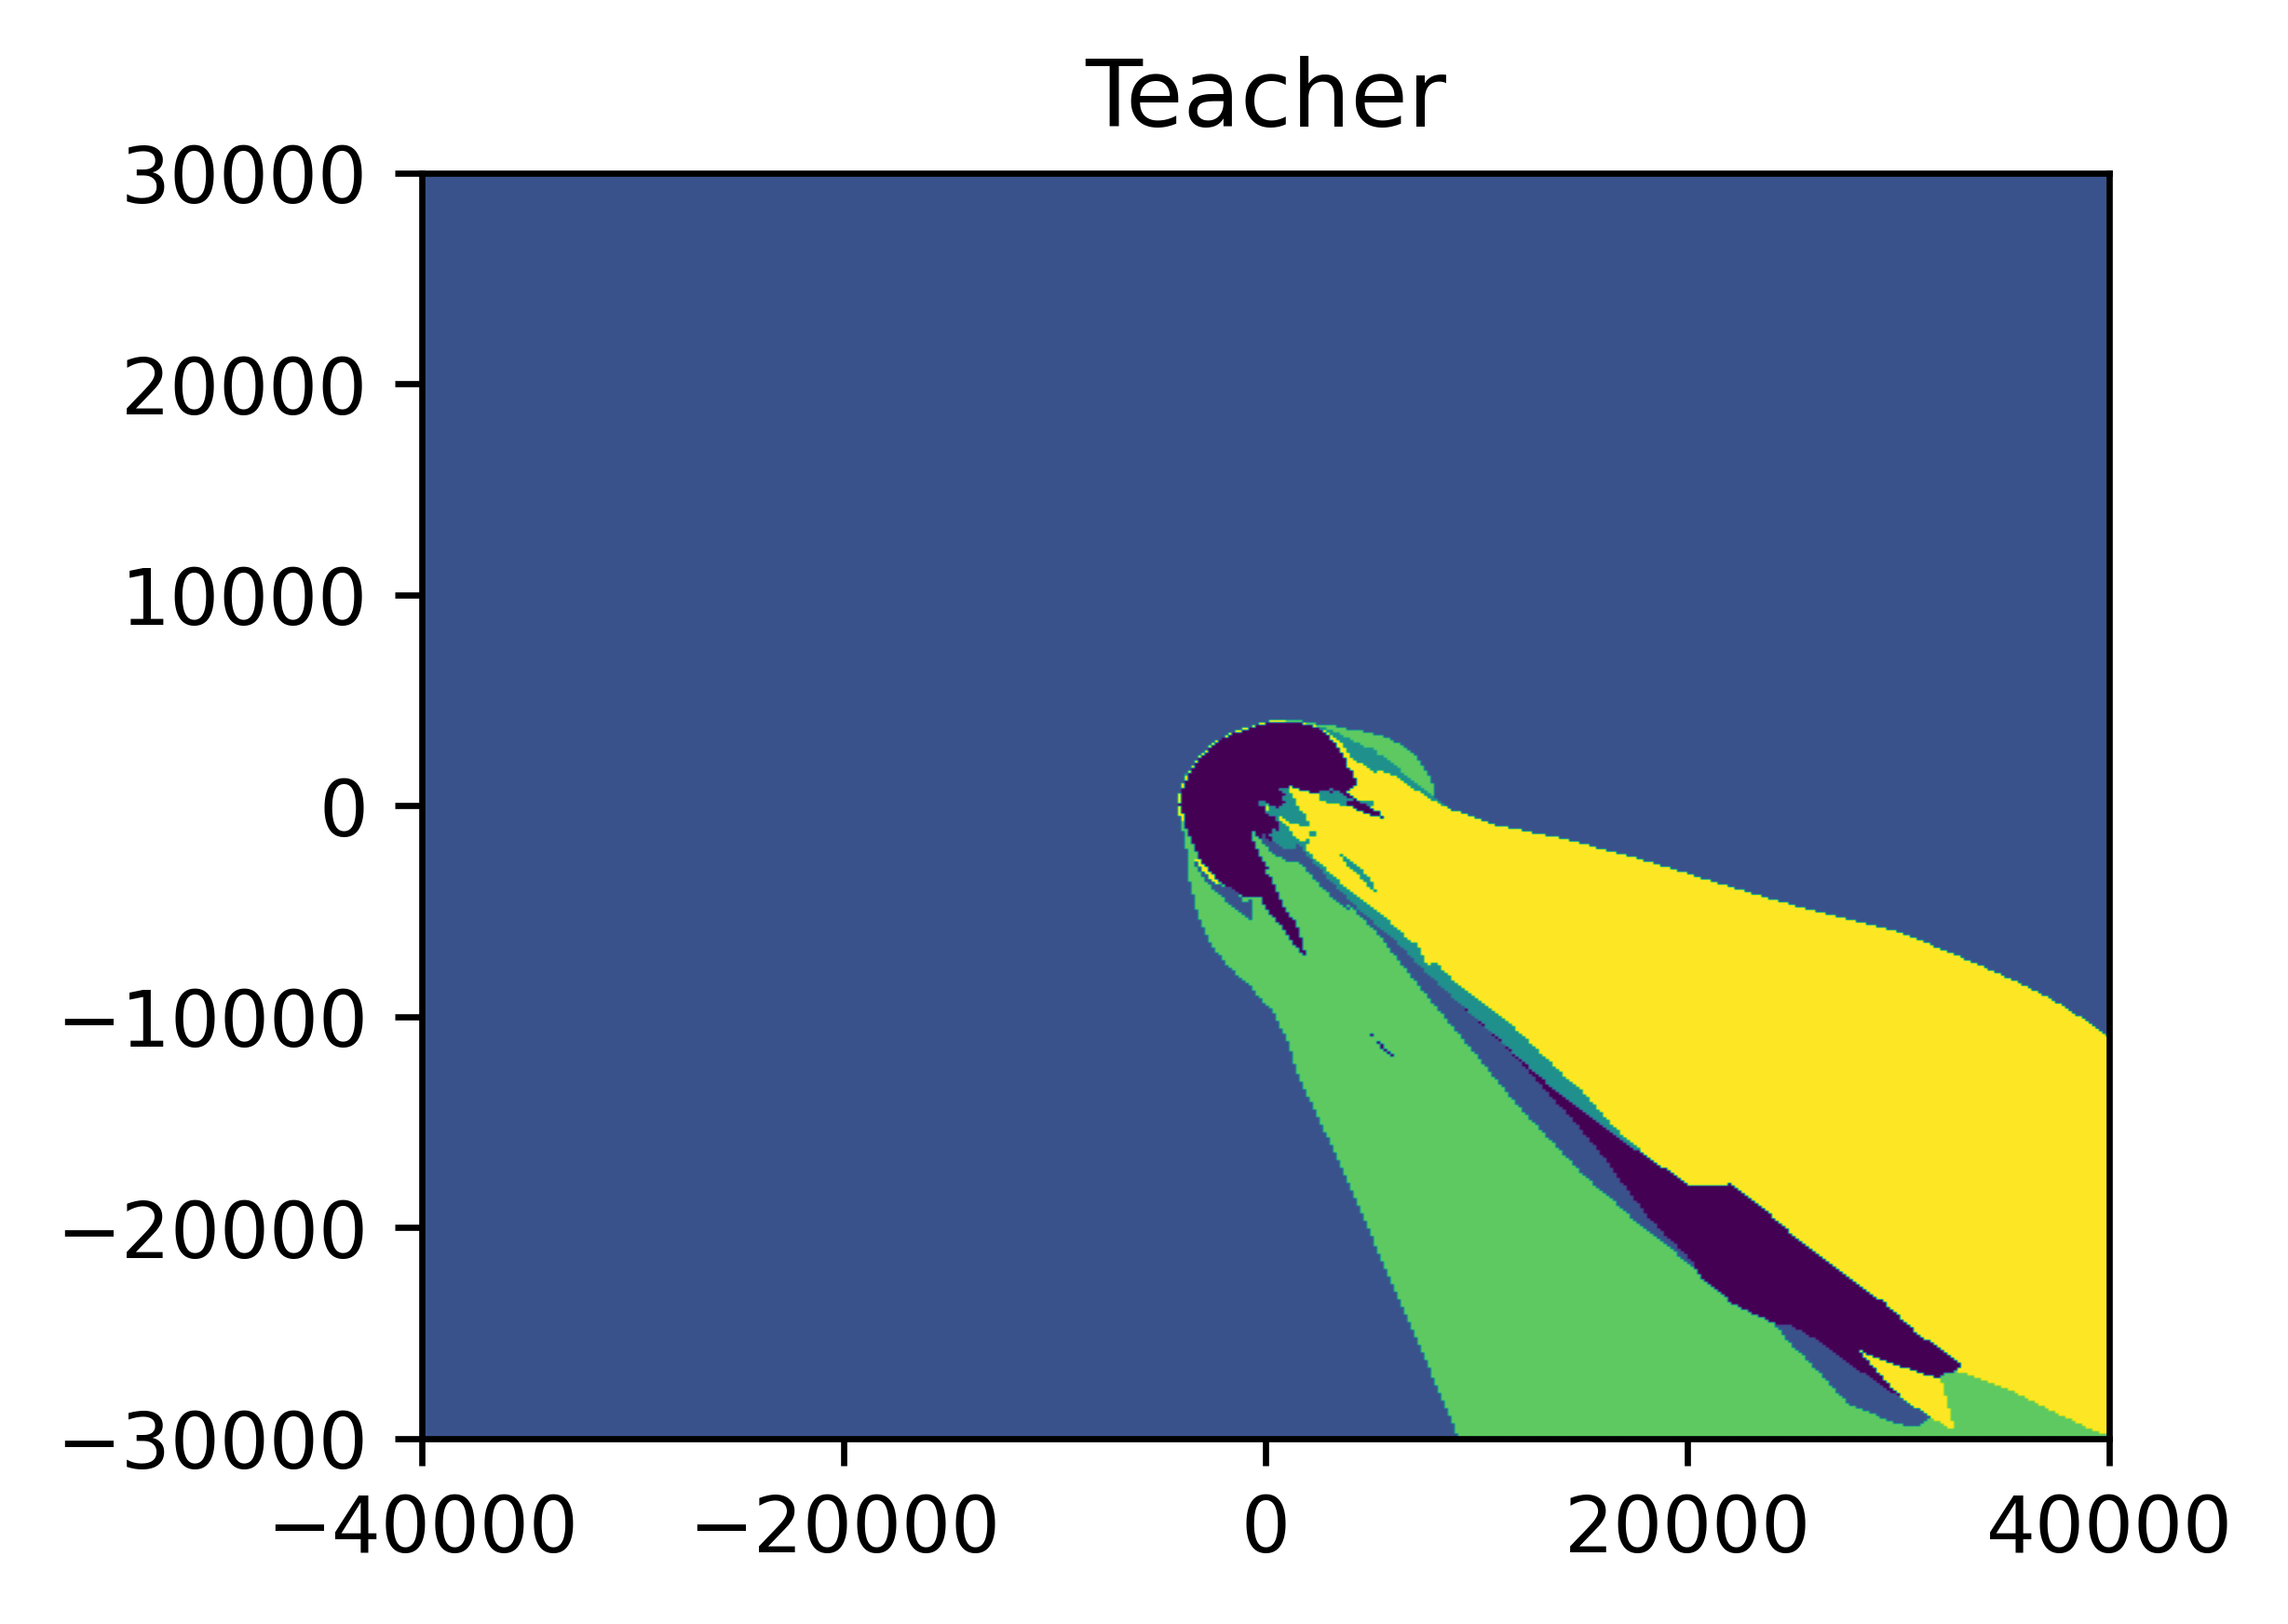

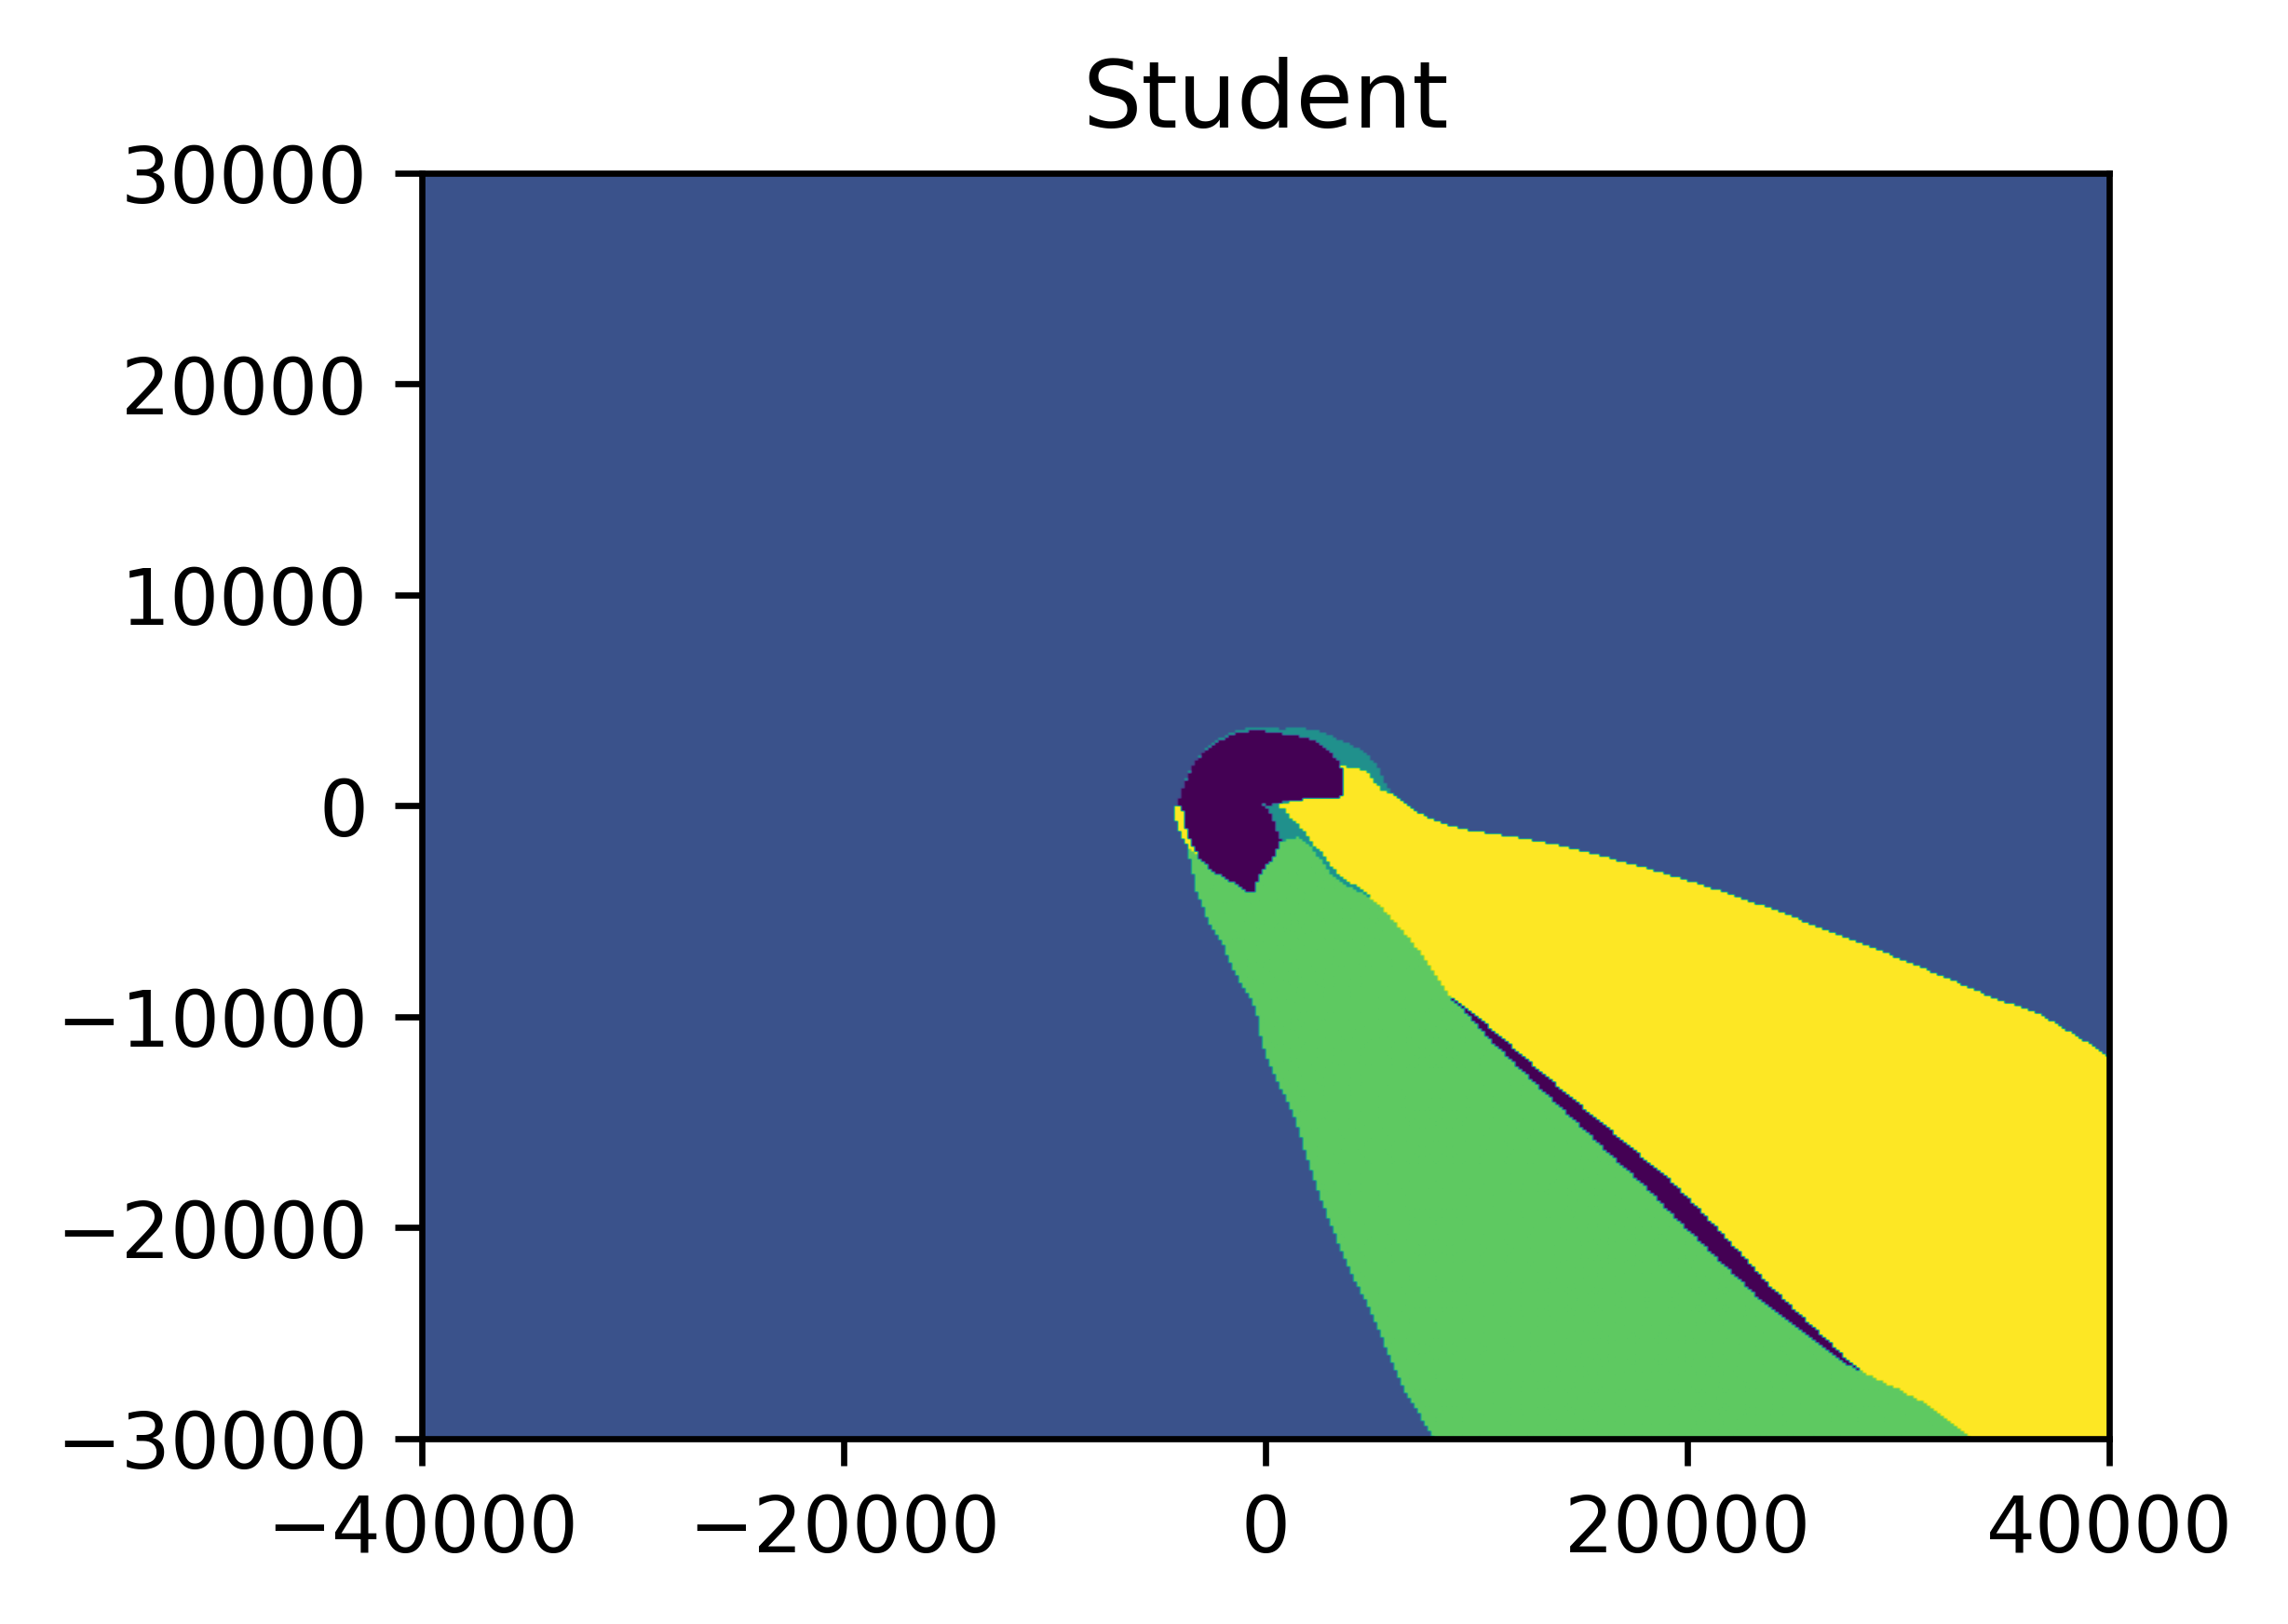

In [26]:
# Input Scaling

nx, ny = (500, 500)

x = np.linspace(-40000,40000, nx)
y = np.linspace(-30000,30000, ny)
xx,yy = np.meshgrid(x,y)

def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

tt,rr = cart2pol(xx,yy)

inputs_here = [rr.flatten(), # Distance between ownship and intruder
               tt.flatten(), # Angle between ownship and intruder
               -np.pi/2, # Angle of intruder relative to angle of ownship
               600, # Velocity of ownship
               600] # Velocity of intruder

## From VNNCOMP repository
means_for_scaling = [19791.091, 0.0, 0.0, 650.0, 600.0, 7.5188840201005975]
range_for_scaling = [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0]

coords = np.zeros(shape=(nx*ny,1,1,5),dtype="float32")
for i in range(5):
    coords[:,0,0,i] = (inputs_here[i] - means_for_scaling[i])/range_for_scaling[i]


teacher_image = acas_xu.run(coords).linear_7_Add.argmax(axis=1)
student_image = student_model.predict(coords.reshape(nx*ny,5)).argmax(axis=1)


extent = -40000, 40000, -30000, 30000
plt.figure(figsize=(4,3),dpi=600)
plt.imshow(teacher_image.reshape(nx,ny), extent=extent)
plt.title("Teacher")
plt.show()

plt.figure(figsize=(4,3),dpi=600)
plt.imshow(student_image.reshape(nx,ny), extent=extent)
plt.title("Student")
plt.show()

## Verify student and teacher networks

Use the 10 properties provided in VNNComp to check if the student network satisfies the safety properties. Produce the following:

- Timing information
- Counterexamples
- Failiure modes of nnenum
- List of verified networks

## NNenum

In [10]:
tf.saved_model.save(student_model, "./distill_test_acas_student_model")

INFO:tensorflow:Assets written to: ./distill_test_acas_student_model/assets


In [11]:
!python -m tf2onnx.convert --saved-model ./distill_test_acas_student_model/ --output distill_test_acas_student_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-07-25 10:20:26,524 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-07-25 10:20:26,773 - INFO - Signatures found in model: [serving_default].
2022-07-25 10:20:26,773 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-07-25 10:20:26,774 - INFO - Output names: ['dense_4']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-07-25 10:20:26,836 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.comp

In [12]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_test_acas_student_model.onnx /my_work/data/acasxu/prop_1.vnnlib

all input names: ['dense_input', 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/MatMul:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense/Relu:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_1/Relu:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_2/Relu:0', 'StatefulPartitionedCall/sequential/dense_3/MatMul/ReadVariabl

In [13]:
!docker run -it -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /my_work/data/acasxu/prop_1.vnnlib

all input names: ['input', 'input_AvgImg', 'input_Sub', 'Operation_1_Flatten', 'Operation_1_MatMul_W', 'Operation_1_MatMul', 'Operation_1_Add_B', 'Operation_1_Add', 'relu_1', 'Operation_2_MatMul_W', 'Operation_2_MatMul', 'Operation_2_Add_B', 'Operation_2_Add', 'relu_2', 'Operation_3_MatMul_W', 'Operation_3_MatMul', 'Operation_3_Add_B', 'Operation_3_Add', 'relu_3', 'Operation_4_MatMul_W', 'Operation_4_MatMul', 'Operation_4_Add_B', 'Operation_4_Add', 'relu_4', 'Operation_5_MatMul_W', 'Operation_5_MatMul', 'Operation_5_Add_B', 'Operation_5_Add', 'relu_5', 'Operation_6_MatMul_W', 'Operation_6_MatMul', 'Operation_6_Add_B', 'Operation_6_Add', 'relu_6', 'linear_7_MatMul_W', 'linear_7_MatMul', 'linear_7_Add_B']
Running in parallel with 6 processes
(0.1 sec) Q: 0, Sets: 0/1  (0.0%) ETA: - (expected 1 stars)   
(0.2 sec) Q: 1, Sets: 6/16  (4.688%) ETA: 3.2 sec (expected 128 stars)   
(0.4 sec) Q: 0, Sets: 151/165  (60.01%) ETA: 0.2 sec (expected 252 stars)   
(0.6 sec) Q: 0, Sets: 281/283  (97.6

## All 10 properties with timing

In [18]:
import subprocess
import re

In [28]:
for prop in range(1,10+1):
    print(f"Property {prop}")

    cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_test_acas_student_model.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
    result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
    print(f"\tStudent:\tTime={runtime_re}\tOutput={result_re}")

    cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/data/acasxu/ACASXU_run2a_1_1_batch_2000.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
    result = subprocess.getoutput(cmd)
    runtime_re = re.search("Runtime: (\d+\.\d+)", result).groups(0)[0]
    result_re = re.search("Result: ([a-zA-Z\s]+)", result).groups(0)[0]
    print(f"\tTeacher:\tTime={runtime_re}\tOutput={result_re}")


    

Property 1
	Student:	Time=0.3	Output=network is SAFE
	Teacher:	Time=0.6	Output=network is SAFE
Property 2
	Student:	Time=0.5	Output=network is SAFE
	Teacher:	Time=1.3	Output=network is SAFE
Property 3
	Student:	Time=0.1	Output=network is SAFE
	Teacher:	Time=1.6	Output=network is SAFE
Property 4
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.6	Output=network is SAFE
Property 5
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=3.2	Output=network is SAFE
Property 6
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=6.4	Output=network is SAFE
Running in parallel with 
Property 7
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Teacher:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
Property 8
	Student:	Time=0.1	Output=network is UNSAFE with confirmed counterexample in result
	Tea

### What do the counterexamples look like?

In [29]:
prop = 4

print(f"Property {prop}")
cmd = f"docker run -v $(PWD):/my_work nnenum_image python3 -m nnenum.nnenum /my_work/distill_test_acas_student_model.onnx /my_work/data/acasxu/prop_{prop}.vnnlib"
result = subprocess.getoutput(cmd)
print(result)



    

Property 4
all input names: ['dense_input', 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/MatMul:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense/Relu:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_1/Relu:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_2/Relu:0', 'StatefulPartitionedCall/sequential/dense_3/MatMul/